### 기본 셋팅 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import seaborn as sns 
from scipy import stats
import os
import platform
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import pandas as pd

if platform.system() == 'Darwin': # Mac
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows
    plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)


df =pd.read_csv("../../data/2.processed/processed_for_analysis.csv")


### 다중회귀 (단순회귀에서 다뤘던 부분 + 중요해 보였던 부분)

#### 종속변수(범죄 유형) 결정

In [3]:
targets = {
    "절도": "절도범죄_전체",
    "풍속": "풍속범죄_전체",
    "지능": "지능범죄_재산범죄",
    "마약": "마약범죄_전체",
}

#### 독립변수(요인) 결정 

In [4]:
x_cols = [
    "청년기_비율",
    "노년기_비율",
    "1인가구비율",
    "여성_비율", #남성 비율은 여성_비율과 중복이라 제외
    "CCTV",
    "경찰서수",
]

#### 다중회귀 모델 적합 코드 

In [5]:
def run_multiple_ols(df,y_col, x_cols):
    use_cols = [y_col] + x_cols
    y = df[y_col]
    X = df[x_cols]
    X = sm.add_constant(X)

    model = sm.OLS(y,X).fit()
    print(f"\n=== 다중회귀: {y_col} ~ {', '.join(x_cols)} ===")
    print(model.summary())
    return model



#### 범죄 유형별로 돌려보기

In [6]:
models = {}
for name, y_col in targets.items():
    models[name] = run_multiple_ols(df, y_col, x_cols)


=== 다중회귀: 절도범죄_전체 ~ 청년기_비율, 노년기_비율, 1인가구비율, 여성_비율, CCTV, 경찰서수 ===
                            OLS Regression Results                            
Dep. Variable:                절도범죄_전체   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     18.98
Date:                Mon, 01 Dec 2025   Prob (F-statistic):           5.22e-18
Time:                        12:58:41   Log-Likelihood:                -433.01
No. Observations:                 243   AIC:                             880.0
Df Residuals:                     236   BIC:                             904.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

#### 2,4 모델(풍속범죄, 마약범죄)는 설명령이 낮음 

#### 계수로 비교 불가(단위 다름), 회계계수 표준화 모델 함수 

In [7]:
def run_multiple_ols_standardized(df, y_col, x_cols):
    use_cols = [y_col] + x_cols
    data = df[use_cols].dropna()
    
    X = data[x_cols]
    y = data[y_col]
    
    # z-score 표준화
    X_z = (X - X.mean()) / X.std()
    y_z = (y - y.mean()) / y.std()
    
    X_z = sm.add_constant(X_z)
    model = sm.OLS(y_z, X_z).fit()
    return model

#### 범죄별 표준화 계수 테이블 생성

In [9]:
import pandas as pd

std_models = {name: run_multiple_ols_standardized(df, y_col, x_cols)
              for name, y_col in targets.items()}

rows = []
for crime_name, m in std_models.items():
    for var in x_cols:
        rows.append({
            "범죄유형": crime_name,
            "변수": var,
            "표준화계수": m.params[var],
            "p값": m.pvalues[var],
            "R2": m.rsquared
        })

coef_df = pd.DataFrame(rows)
coef_df

,범죄유형,변수,표준화계수,p값,R2
0,절도,청년기_비율,0.017432,9.129837e-01,0.325452
1,절도,노년기_비율,-0.421842,1.552100e-02,0.325452
2,절도,1인가구비율,0.437179,1.050908e-08,0.325452
3,절도,여성_비율,0.280737,1.933790e-06,0.325452
4,절도,CCTV,0.056113,4.039759e-01,0.325452
5,절도,경찰서수,-0.078044,1.874264e-01,0.325452
6,풍속,청년기_비율,0.136923,4.750558e-01,0.027014
7,풍속,노년기_비율,0.074932,7.187693e-01,0.027014
8,풍속,1인가구비율,0.029673,7.376861e-01,0.027014
9,풍속,여성_비율,0.113051,1.029672e-01,0.027014


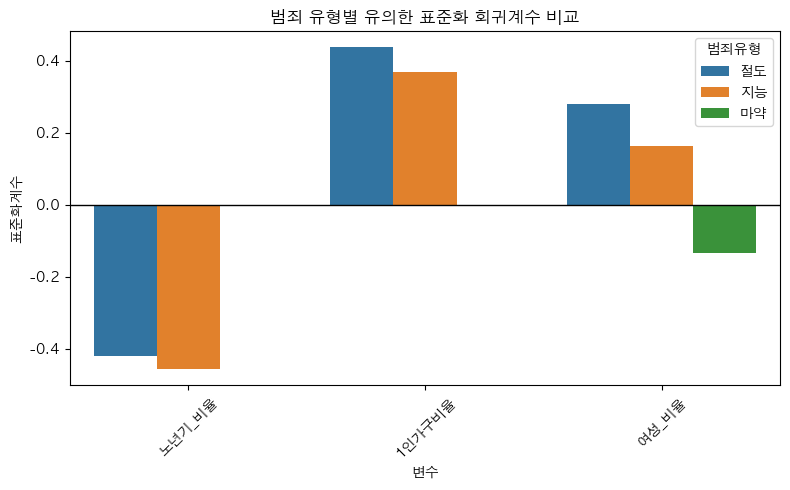

In [11]:

plt.figure(figsize=(8,5))
sns.barplot(
    data=coef_df[coef_df["p값"] < 0.05],  # 유의한 것만 보려면 필터
    x="변수", y="표준화계수", hue="범죄유형"
)
plt.axhline(0, color="black", linewidth=1)
plt.title("범죄 유형별 유의한 표준화 회귀계수 비교")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
def plot_actual_vs_pred(model, y_series, title):
    fitted = model.fittedvalues
    y_used = y_series.loc[model.model.data.row_labels]
    
    plt.figure(figsize=(5,4))
    plt.scatter(fitted, y_used, alpha=0.6)
    min_v, max_v = min(fitted.min(), y_used.min()), max(fitted.max(), y_used.max())
    plt.plot([min_v, max_v], [min_v, max_v], 'r--')
    plt.xlabel("예측값")
    plt.ylabel("실제값")
    plt.title(title)
    plt.grid(True)
    plt.show()

#### 유의한 모델 plot


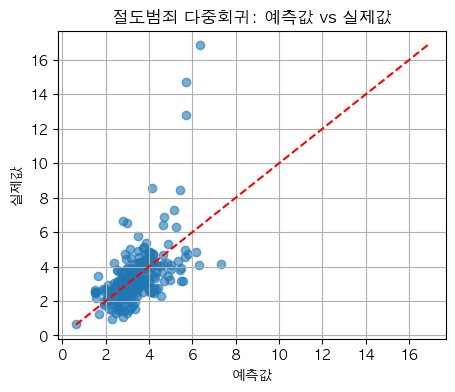

In [ ]:
plot_actual_vs_pred(models["절도"],
                    df["절도범죄_전체"],
                    "절도범죄 다중회귀: 예측값 vs 실제값")

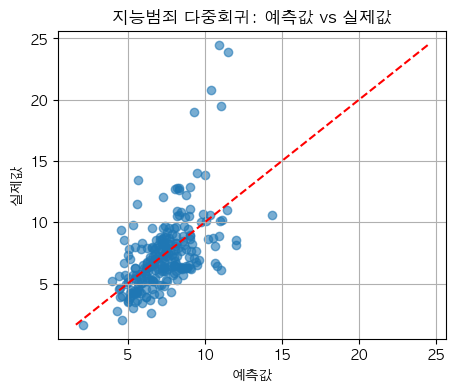

In [18]:
plot_actual_vs_pred(
    models["지능"],
    df["지능범죄_재산범죄"],
    "지능범죄 다중회귀: 예측값 vs 실제값"
)

### 결론 

### 다중회귀 분석 결과 (가설 관점 정리)

#### (1) 절도범죄_전체

- R² = 0.325, Adj R² = 0.308으로 **단순회귀(0.146)에 비해 설명력이 크게 향상**되었다.
- 유의한 변수: **1인가구비율(+)**, **여성_비율(+)**, **노년기_비율(−)**  
  - 1인가구비율이 1%p 증가할수록 절도범죄율은 증가(양의 계수, p<0.001)  
  - 여성_비율이 높을수록 절도범죄율 증가(양의 계수, p<0.001)  
  - 노년기_비율이 높을수록 절도범죄율 감소(음의 계수, p<0.05)
- 청년기_비율은 다중회귀에서 **계수≈0, p≈0.91로 유의하지 않음**.  
  → 단순회귀에서 관찰된 “청년기 비율↑ → 절도범죄↑” 효과는  
  **1인가구 및 여성 인구 비중 등 다른 인구구조 특성과의 공선성**에 의한 간접 효과로 보는 것이 타당하다.

**→ 가설 관점 정리**
- **B1: 청년기 비율↑ → 절도범죄율↑**  
  - 단순회귀에서는 지지, 다중회귀에서는 비유의 →  
    **다른 변수들을 통제하면 ‘독립적인 효과’는 사라짐 → 실질적으로 기각에 가까움**
---

#### (2) 지능범죄_재산범죄

- R² = 0.325, Adj R² = 0.308로 절도와 유사한 수준의 **꽤 높은 설명력**을 보였다.
- 유의한 변수: **1인가구비율(+)**, **여성_비율(+)**, **노년기_비율(−)**  
  - 1인가구비율↑ → 지능범죄율↑ (양의 계수, p<0.001)  
  - 여성_비율↑ → 지능범죄율↑ (양의 계수, p≈0.005)  
  - 노년기_비율↑ → 지능범죄율↓ (음의 계수, p≈0.009)
- 청년기_비율, CCTV, 경찰서수는 p>0.05로 유의하지 않음.
- 이는 1인가구와 여성 비중이 높은 도시형 지역에서 지능형 재산범죄가
  상대적으로 많이 발생하는 반면, **노년층 비중이 높은 지역에서는 이러한 범죄가 감소**하는 경향을 시사한다.

**→ 가설 관점 정리**

- **B3: 노년기 비율↑ → 지능범죄율↓**  
  - 단순·다중회귀 모두에서 음(-)의 계수, p<0.01 → **B3는 강하게 지지**.


#### (3) 풍속범죄_전체

- R² = 0.027, Adj R² = 0.002로 **설명력이 매우 낮고**,  
  F-검정 p=0.368으로 **모형 전체도 유의하지 않음**.
- 모든 독립변수(청년기_비율, 노년기_비율, 1인가구비율, 여성_비율, CCTV, 경찰서수)의
  p-value가 0.05를 크게 상회하여 **어느 것도 유의하지 않다**.
- 현재 사용한 인구·환경 변수만으로는 풍속범죄 수준을 설명하기 어렵고,
  상권 특성, 유흥가 밀집도 등 **다른 요인이 필요함**을 보여준다.

**→ 가설 관점 정리**

- **B2: 청년기 비율↑ → 풍속범죄율↑**  
  - 단순회귀에서도 비유의, 다중회귀에서도 비유의 + R² 거의 0 →  
    **B2는 명확히 기각**.


---

#### (4) 마약범죄_전체

- R² = 0.057, Adj R² = 0.033으로 **설명력은 낮지만**,  
  F-검정 p ≈ 0.028로 **모형 전체는 유의**하다.
- 변수별로 보면:
  - **여성_비율**: 약한 음(-)의 관계, p≈0.048 (유의)  
    → 여성 비중이 높을수록 마약범죄율은 소폭 감소하는 경향
  - 청년기_비율(p≈0.053), 노년기_비율(p≈0.060): 0.05 근처의 경계선 수준  
  - 1인가구비율, CCTV, 경찰서수: p>0.3로 비유의
- 단순회귀에서 유의했던 1인가구비율의 효과는,  
  **다른 인구구조 변수를 함께 고려하면 사라지는 것**으로 나타났다.

**→ 가설 관점 정리**

- **B4: 1인가구 비율↑ → 마약범죄율↑**  
  - 단순회귀: 양(+) 계수, p<0.01이지만 R² 매우 낮음  
  - 다중회귀: 1인가구비율 계수 비유의 →  
    **다른 변수들을 통제하면 독립적인 효과가 사라짐**  
  → **“단순회귀 수준에서는 약하게 지지되지만, 다중회귀 기준에서는 지지되지 않음”**이라고 정리하는 것이 적절하다.